In [9]:
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import kmedoids
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from collections import Counter
from sklearn.manifold import TSNE

In [7]:
!pip install datasets scikit-learn matplotlib numpy seaborn pandas

In [8]:
!pip install kmedoids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

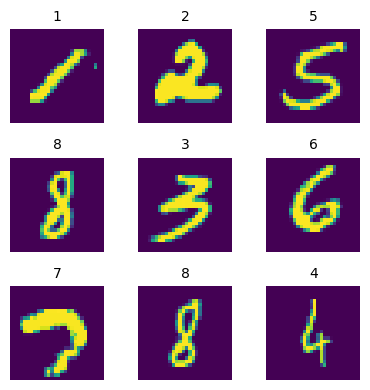

In [10]:
dataset = load_dataset("mnist", split="train[:5000]")
dataset = dataset.shuffle(seed=42)

fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = dataset[i]["image"]
    label = dataset.features["label"].int2str(dataset[i]["label"])
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [25]:
X = np.array([np.array(img.resize((64, 64))).flatten()
              for img in dataset["image"]], dtype=np.float32)
X = X / 255.0  # normalize to [0, 1]

print("Data shape:", X.shape)  # (N, 64*64*3)


# Reduce to 50 dimensions (you can tune this number)
pca = PCA(n_components=786, random_state=42)
X = pca.fit_transform(X)


# 3. Extract labels

y = np.array(dataset["label"])
label_names = dataset.features["label"].names

print("Labels shape:", y.shape)

# 4. Count unique clusters

unique_labels, counts = np.unique(y, return_counts=True)
n_classes = len(unique_labels)

print("\nNumber of unique clusters (classes):", n_classes)
print("Allclasses:")
for i in range(n_classes):
    print(f"{unique_labels[i]} -> {label_names[unique_labels[i]]} ({counts[i]} samples)")

Data shape: (5000, 4096)
Labels shape: (5000,)

Number of unique clusters (classes): 10
Allclasses:
0 -> 0 (479 samples)
1 -> 1 (563 samples)
2 -> 2 (488 samples)
3 -> 3 (493 samples)
4 -> 4 (535 samples)
5 -> 5 (434 samples)
6 -> 6 (501 samples)
7 -> 7 (550 samples)
8 -> 8 (462 samples)
9 -> 9 (495 samples)


In [26]:
#This is a helper function that will help you visualize the top 5 datapoints in each cluster
def show_closest_images(X, dataset, centroids, labels, title, num_images=5):
    n_clusters = len(centroids)
    fig, axes = plt.subplots(n_clusters, num_images, figsize=(1.2*num_images, 1.2*n_clusters))


    # If only 1 cluster, fix axes shape
    if n_clusters == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, centroid in enumerate(centroids):
        distances = np.linalg.norm(X - centroid, axis=1)
        cluster_indices = np.where(labels == i)[0]

        if len(cluster_indices) == 0:
            continue

        closest_indices = cluster_indices[np.argsort(distances[cluster_indices])[:num_images]]

        for j, idx in enumerate(closest_indices):
            try:
                img = dataset[int(idx)]["image"]
            except:
                img = dataset[int(idx)]["img"]
            label_name = dataset.features["label"].int2str(dataset[int(idx)]["label"])

            axes[i, j].imshow(img)
            axes[i, j].axis("off")

            axes[i, j].text(0.5, -0.15, label_name,
                            size=7, ha="center", va="top", transform=axes[i, j].transAxes)

            if j == 0:
                axes[i, j].set_title(f"Cluster {i}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [27]:
k = 10  # because MNIST has 10 digit classes (0–9)

kmeans = KMeans(
    n_clusters=k,
    init="random",       # KMeans default random init
    n_init=10,           # 10 different centroid seeds
    max_iter=50,         # stop after 50 iterations
    random_state=42      # reproducibility
)

labels_km = kmeans.fit_predict(X)
# ----------------------------
# Implementation ends here
# ----------------------------

# Reduce to 2D for visualization (t-SNE projection)
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

In [14]:
confused_pairs = []

for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 1:  # at least two different labels in this cluster
        counts = Counter(true_labels).most_common(2)
        most_common, most_count = counts[0]
        second_common, second_count = counts[1]

        if second_count > 50:  # threshold given in assignment
            confused_pairs.append((most_common, second_common))

print("Answer:", confused_pairs)


Answer: [(np.int64(1), np.int64(5)), (np.int64(4), np.int64(9)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(9)), (np.int64(8), np.int64(3)), (np.int64(3), np.int64(5))]


In [17]:
k = 10  # MNIST has 10 digits

kmeans_pp = KMeans(
    n_clusters=k,
    init="k-means++",  # this enables KMeans++
    n_init=10,         # 10 random initializations
    max_iter=50,       # maximum iterations
    random_state=42    # reproducibility
)
labels_pp = kmeans_pp.fit_predict(X)
centroids_pp = kmeans_pp.cluster_centers_  # optional for show_closest_images
# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_pp, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans++ (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


Answer: [(np.int64(7), np.int64(9)), (np.int64(3), np.int64(5)), (np.int64(8), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(4), np.int64(9))]


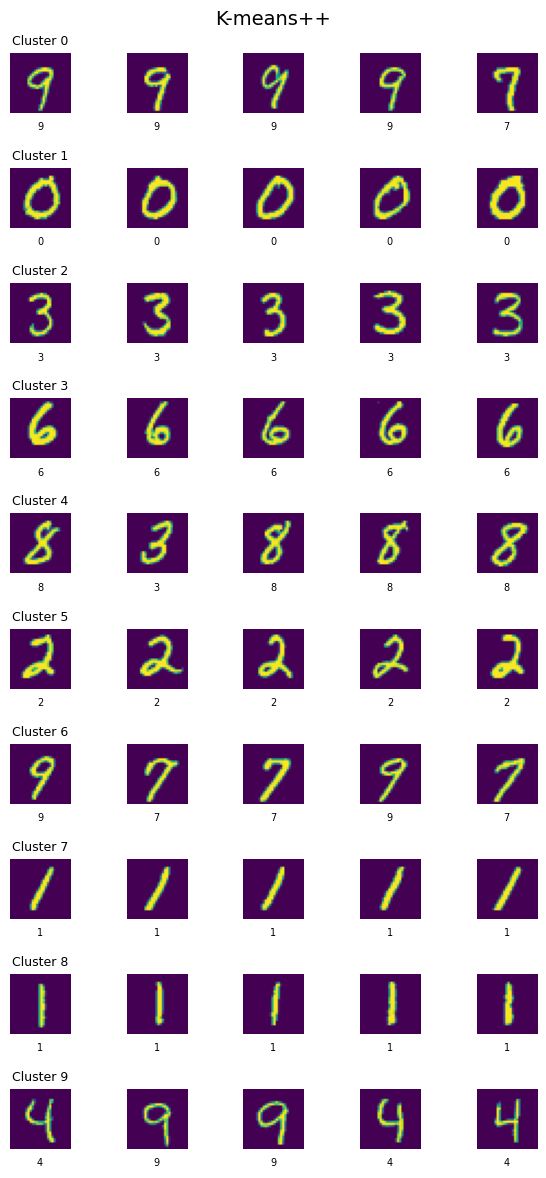

In [18]:
from collections import Counter
import numpy as np

# ----------------------------
# Find Confused Digit Pairs in KMeans++
# ----------------------------
confused_pairs_pp = []
confused_clusters_pp = []

for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]

    if len(true_labels) > 1:  # at least two different labels in the cluster
        counts = Counter(true_labels).most_common(2)
        most_common, most_count = counts[0]
        second_common, second_count = counts[1]

        if second_count > 50:  # threshold given in assignment
            confused_pairs_pp.append((most_common, second_common))
            confused_clusters_pp.append(cluster_id)  # optional, can use for highlighting

print("Answer:", confused_pairs_pp)

# ----------------------------
# Visualize closest images to KMeans++ centroids
# ----------------------------
show_closest_images(X, dataset, centroids_pp, labels_pp, "K-means++")


Confused digit pairs (KMedoids): [(np.int64(9), np.int64(8)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(3)), (np.int64(9), np.int64(4)), (np.int64(2), np.int64(1)), (np.int64(5), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(1), np.int64(3))]
Confused cluster IDs (KMedoids): [1, 2, 3, 4, 5, 6, 7, 9]


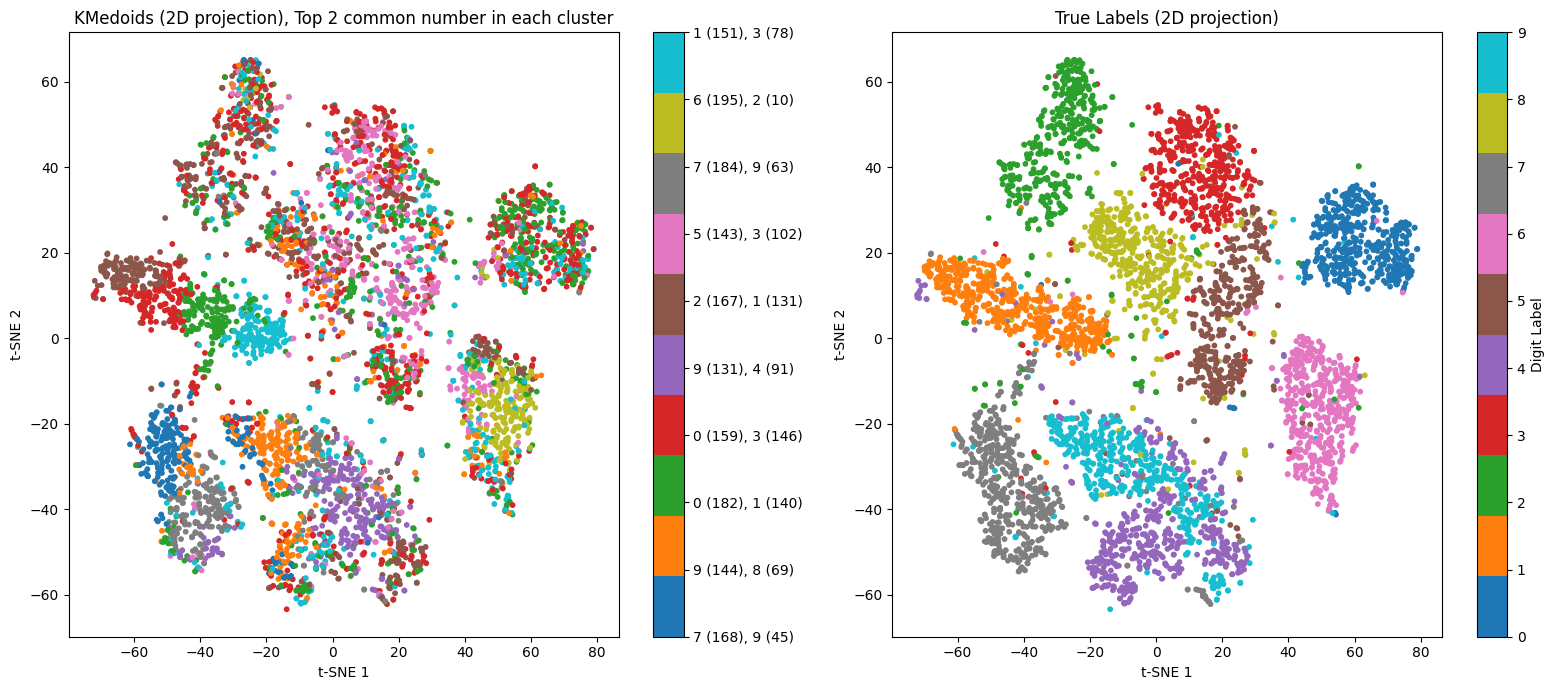

In [19]:
# ----------------------------
# KMedoids Clustering
# ----------------------------
from sklearn.metrics import pairwise_distances
from kmedoids import KMedoids
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

k = 10  # MNIST digits

# Step 1: Compute precomputed distance matrix (Manhattan distance)
dist_matrix = pairwise_distances(X, metric="manhattan")

# Step 2: Initialize and fit KMedoids
kmedoids = KMedoids(
    n_clusters=k,
    metric="precomputed",  # distance matrix
    method="fasterpam",    # efficient PAM algorithm
    random_state=42
)

labels_kmed = kmedoids.fit_predict(dist_matrix)
medoids = kmedoids.medoid_indices_  # optional, for visualization if needed

# ----------------------------
# Find Confused Digit Pairs (like KMeans)
# ----------------------------
confused_pairs_kmed = []
confused_clusters_kmed = []

for cluster_id in range(k):
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]

    if len(true_labels) > 1:
        counts = Counter(true_labels).most_common(2)
        most_common, most_count = counts[0]
        second_common, second_count = counts[1]

        if second_count > 50:
            confused_pairs_kmed.append((most_common, second_common))
            confused_clusters_kmed.append(cluster_id)

print("Confused digit pairs (KMedoids):", confused_pairs_kmed)
print("Confused cluster IDs (KMedoids):", confused_clusters_kmed)

# ----------------------------
# t-SNE Visualization
# ----------------------------
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMedoids clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmed, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMedoids (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


In [20]:
confused_pairs_kmed = []
confused_clusters_kmed = []

for cluster_id in range(k):
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]

    if len(true_labels) > 1:  # at least two different labels in cluster
        counts = Counter(true_labels).most_common(2)
        most_common, most_count = counts[0]
        second_common, second_count = counts[1]

        if second_count > 50:  # threshold
            confused_pairs_kmed.append((most_common, second_common))
            confused_clusters_kmed.append(cluster_id)  # optional, for highlighting

print("Answer:", confused_pairs_kmed)


Answer: [(np.int64(9), np.int64(8)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(3)), (np.int64(9), np.int64(4)), (np.int64(2), np.int64(1)), (np.int64(5), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(1), np.int64(3))]


In [21]:
from sklearn.metrics import silhouette_score

# ----------------------------
# Compute Silhouette Scores
# ----------------------------

# 1. KMeans (random init)
sil_km_rand = silhouette_score(X, labels_km)  # uses Euclidean distance by default

# 2. KMeans++
sil_km_pp = silhouette_score(X, labels_pp)    # Euclidean distance

# 3. KMedoids
# Since KMedoids was fitted with a precomputed distance matrix, pass it and set metric="precomputed"
sil_kmed = silhouette_score(dist_matrix, labels_kmed, metric="precomputed")

# ----------------------------
# Display results
# ----------------------------
import pandas as pd

results = pd.DataFrame({
    "Algorithm": ["KMeans", "KMeans++", "KMedoids"],
    "Silhouette Score": [sil_km_rand, sil_km_pp, sil_kmed]
})

results


Algorithm  Silhouette Score
0    KMeans          0.071394
1  KMeans++          0.069799
2  KMedoids          0.004066

Kmeans is doing the best amongst the three.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import rescale

# ----------------------------
# Load and preprocess image
# ----------------------------
image = imread("image0.png")
image = rescale(image, 0.5, channel_axis=-1)  # resize to 50%
image_shape = image.shape
pixels = image.reshape(-1, image_shape[-1])  # flatten to (num_pixels, 3)

k = 5  # number of color clusters

# ----------------------------
# KMeans (random init)
# ----------------------------
kmeans_rand = KMeans(
    n_clusters=k,
    init="random",
    n_init=10,
    max_iter=50,
    random_state=42
)
labels_rand = kmeans_rand.fit_predict(pixels)
centers_rand = kmeans_rand.cluster_centers_

# Reconstruct image with cluster centers
quantized_rand = centers_rand[labels_rand].reshape(image_shape)

# ----------------------------
# KMeans++ (smart init)
# ----------------------------
kmeans_pp = KMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    max_iter=50,
    random_state=42
)
labels_pp = kmeans_pp.fit_predict(pixels)
centers_pp = kmeans_pp.cluster_centers_

# Reconstruct image with cluster centers
quantized_pp = centers_pp[labels_pp].reshape(image_shape)

# ----------------------------
# Display results
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(quantized_rand)
axes[1].set_title("KMeans (random)")
axes[1].axis("off")

axes[2].imshow(quantized_pp)
axes[2].set_title("KMeans++")
axes[2].axis("off")

plt.tight_layout()
plt.show()


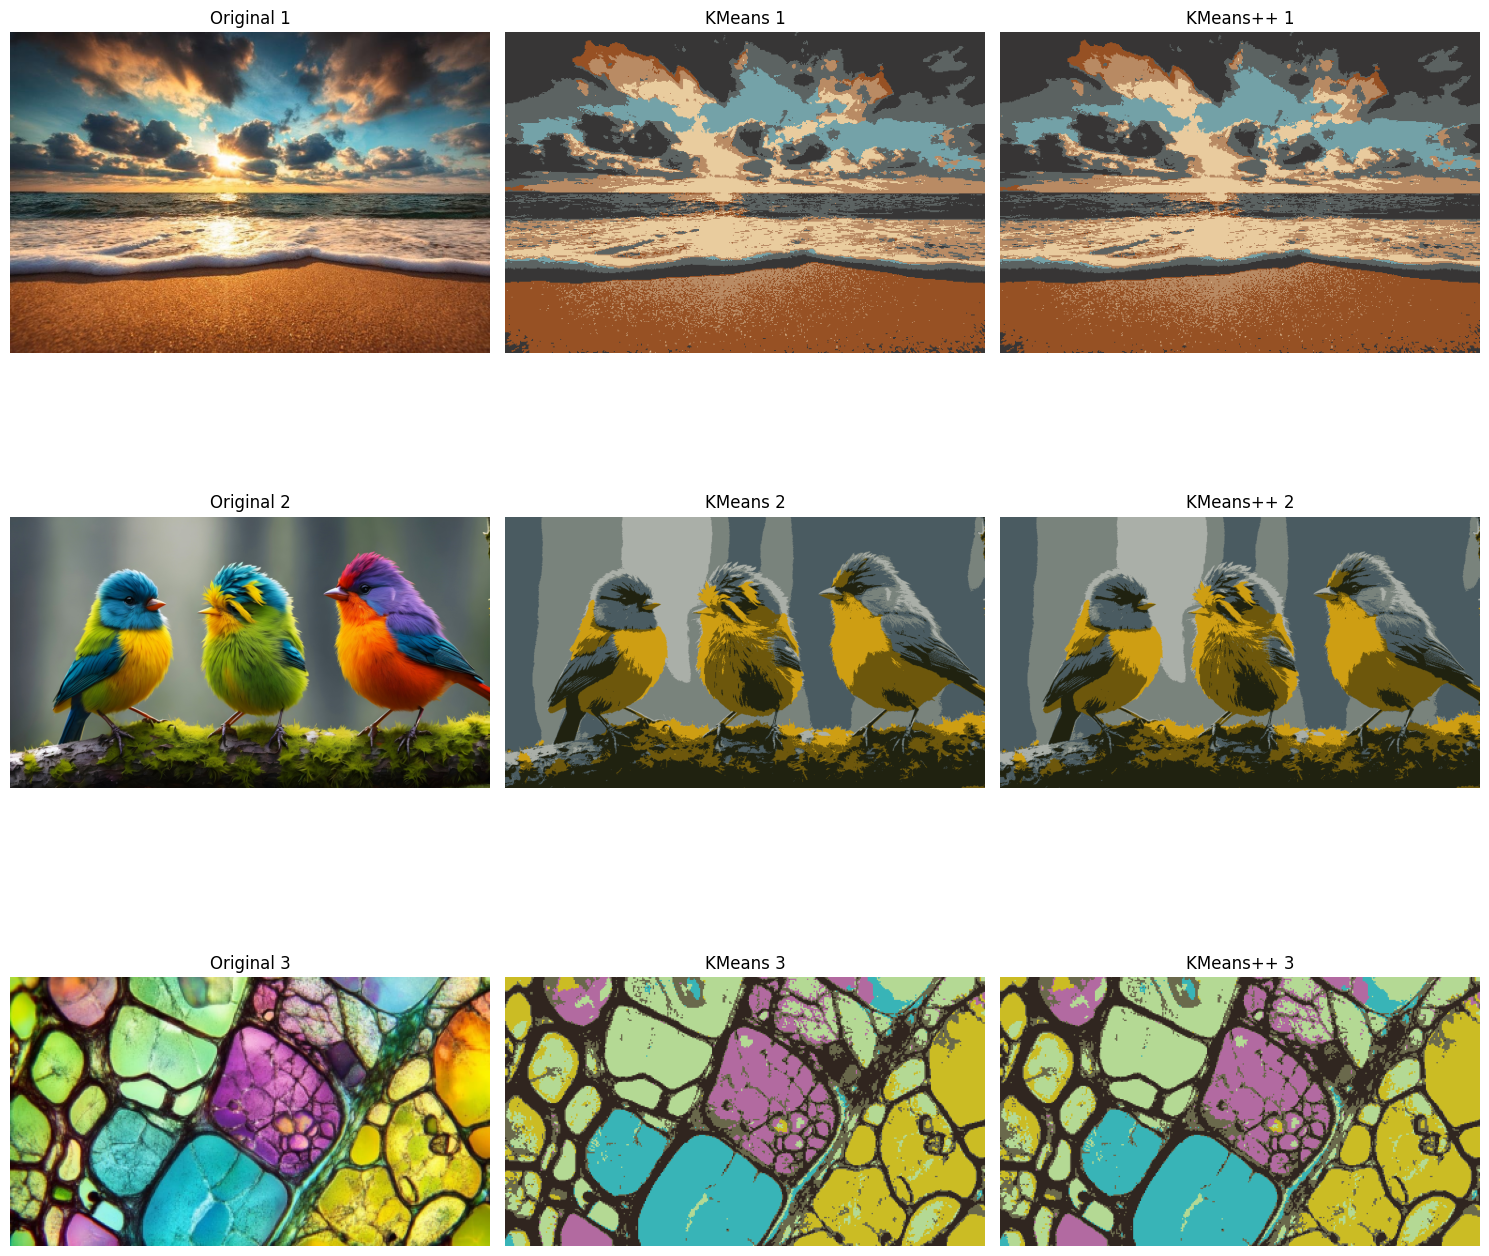

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import rescale

def cluster_image(image_path, k=5):
    # Load and preprocess image
    image = imread(image_path)
    image = rescale(image, 0.5, channel_axis=-1)  # resize to 50%
    h, w, c = image.shape
    pixels = image.reshape(-1, c)

    # ----------------------------------------------
    # KMeans (Random Init)
    # ----------------------------------------------
    kmeans_rand = KMeans(
        n_clusters=k,
        init="random",
        n_init=10,
        max_iter=50,
        random_state=42
    )
    labels_rand = kmeans_rand.fit_predict(pixels)
    centers_rand = kmeans_rand.cluster_centers_
    kmeans_image = centers_rand[labels_rand].reshape(h, w, c)

    # ----------------------------------------------
    # KMeans++ (Smart Init)
    # ----------------------------------------------
    kmeans_pp = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=50,
        random_state=42
    )
    labels_pp = kmeans_pp.fit_predict(pixels)
    centers_pp = kmeans_pp.cluster_centers_
    kmeans_pp_image = centers_pp[labels_pp].reshape(h, w, c)

    # ----------------------------------------------
    # Implementation ends here
    # ----------------------------------------------

    return image, kmeans_image, kmeans_pp_image

# List of image paths
images = ["image1.jpg", "image2.jpg", "image3.jpg"]

# Process each image
results = [cluster_image(img, k=6) for img in images]

# Display in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (orig, km_rand, km_pp) in enumerate(results):
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(km_rand)
    axes[i, 1].set_title(f"KMeans {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(km_pp)
    axes[i, 2].set_title(f"KMeans++ {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


1. Question: What does the Silhouette Score of KMeans++ for MNIST dataset represent?

Answer:
It measures how well-separated and cohesive the clusters are; a higher score means digits are grouped tightly within clusters and well-separated from other clusters.

2. Question: When you used the KMeans library you set n_init = 10. What does n_init do?

Answer:
It specifies the number of times KMeans will run with different centroid initializations and chooses the best result with the lowest inertia.

3. Question: When you used the KMeans library you set max_iter = 50. What does max_iter do?

Answer:
It sets the maximum number of iterations KMeans will perform for a single run before stopping, even if it hasn’t fully converged.

4. Question: What distance metric did you use for computing the Silhouette score of KMedoids?

Answer:
The precomputed Manhattan distance (L1 distance) that was used in the KMedoids clustering.